Train Regression (3 CLIP scores, and T -> predict best T) Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
np.random.seed(random_seed)
random.seed(random_seed)

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Load Data

In [2]:
save_path = Path('/home/lbw/CLODE/scores_csv_4prompts_400600')
vit_path = Path('/home/lbw/CLODE/vit_L_224_csv')

# (485, 2): 485개 이미지에 대한, best T값과 그때의 PSNR
# lq_iqa_scores = np.load(save_path / 'clip_features.npy')
lq_iqa_scores = np.load(vit_path / 'vit_features_L.npy')
results = np.load(save_path / 'results.npy')

In [3]:
lq_iqa_scores = np.array(lq_iqa_scores).squeeze()
results = np.array(results)
print(lq_iqa_scores.shape, results.shape)
print(lq_iqa_scores)
print(results)

NUM_IMAGES = results.shape[0]
# NUM_T = 30

(485, 1000) (485, 2)
[[-0.5581784   0.3067726  -0.41295195 ...  0.22341835  0.10755076
   0.4652844 ]
 [-0.42466033 -0.06219726 -0.14315256 ...  0.03900237  0.10651902
   0.7117088 ]
 [-0.7466695  -0.6652251  -0.18410444 ... -0.9111844  -1.8889836
   2.0276165 ]
 ...
 [-0.41667703 -0.18047443 -0.21913263 ...  0.2981966  -0.04470444
   0.49063843]
 [-0.40077782 -0.17208192 -0.21248469 ...  0.23757516 -0.10311456
   0.5714481 ]
 [-0.41935953 -0.05070345 -0.1308594  ...  0.02816163  0.10007091
   0.7073287 ]]
[[ 3.03448276 24.44072533]
 [ 3.44827586 21.19199753]
 [ 2.93103448 23.75722694]
 [ 2.         23.91546249]
 [ 3.75862069 18.76879311]
 [ 4.27586207 15.84432602]
 [ 3.44827586 22.88473511]
 [ 3.55172414 23.61591721]
 [ 5.         13.62446976]
 [ 4.06896552 24.48760033]
 [ 2.31034483 29.27861023]
 [ 2.20689655 25.68400955]
 [ 4.89655172 17.62425232]
 [ 5.         15.13490772]
 [ 4.68965517 18.58676529]
 [ 3.24137931 22.01280594]
 [ 4.79310345 19.1254158 ]
 [ 5.         17.26249886]
 [

In [4]:
brightness = np.load(save_path / 'brightness_scores_L.npy')
noisiness = np.load(save_path / 'noisiness_scores_L.npy')
quality = np.load(save_path / 'quality_scores_L.npy')

brightness = np.array(brightness)
noisiness = np.array(noisiness)
quality = np.array(quality)
print(brightness.shape, noisiness.shape, quality.shape)
print(brightness)


(485, 1) (485, 1) (485, 1)
[[0.02533761]
 [0.02518816]
 [0.03170918]
 [0.0318585 ]
 [0.02481888]
 [0.02485519]
 [0.0252632 ]
 [0.02525414]
 [0.02524681]
 [0.02525259]
 [0.02524541]
 [0.02533549]
 [0.02530645]
 [0.02534831]
 [0.02524813]
 [0.02524339]
 [0.02525386]
 [0.02522242]
 [0.02526926]
 [0.02512609]
 [0.02526691]
 [0.02526973]
 [0.02530866]
 [0.02537655]
 [0.02538065]
 [0.02531219]
 [0.02529116]
 [0.02509555]
 [0.02510713]
 [0.02501746]
 [0.02521318]
 [0.02499444]
 [0.0250163 ]
 [0.02499077]
 [0.02515128]
 [0.02516724]
 [0.02519861]
 [0.02520577]
 [0.02510106]
 [0.02520643]
 [0.02509322]
 [0.02528895]
 [0.02526362]
 [0.02516209]
 [0.02519682]
 [0.02507922]
 [0.02492259]
 [0.02515746]
 [0.02519336]
 [0.02497353]
 [0.02538613]
 [0.02540945]
 [0.02514492]
 [0.02492213]
 [0.0252448 ]
 [0.02519439]
 [0.02522312]
 [0.02520723]
 [0.0252061 ]
 [0.02522884]
 [0.02546363]
 [0.02522682]
 [0.02522373]
 [0.02514249]
 [0.02524592]
 [0.02526701]
 [0.02525324]
 [0.02544688]
 [0.02521088]
 [0.025

In [5]:
import numpy as np

# 예시 배열 (실제 코드에서는 이미 정의되어 있음)
# lq_iqa_scores: 485x768 크기
# brightness_scores, noisiness_scores, quality_scores: 각각 485x1 크기

# 먼저 세 가지 스코어를 하나로 결합 (485x3)
all_scores = np.hstack([brightness, noisiness, quality])

# 확인
print(f"결합된 스코어 배열 크기: {all_scores.shape}")  # (485, 3)

# lq_iqa_scores(485x768)와 all_scores(485x3)를 결합하여 485x771 만들기
combined_features = np.hstack([lq_iqa_scores, all_scores])

# 확인
print(f"최종 결합된 특성 배열 크기: {combined_features.shape}")  # (485, 771)

# 원래 변수에 다시 할당 (필요한 경우)
lq_iqa_scores = combined_features

결합된 스코어 배열 크기: (485, 3)
최종 결합된 특성 배열 크기: (485, 1003)


In [6]:
# X = np.zeros((NUM_IMAGES, NUM_T, 3))

# for i in range(NUM_IMAGES):
#     for j in range(NUM_T):
#         X[i, j, 0] = brightness_scores[i * NUM_T + j, 2]
#         X[i, j, 1] = noisiness_scores[i * NUM_T + j, 2]
#         X[i, j, 2] = quality_scores[i * NUM_T + j, 2]

X = lq_iqa_scores
y = results[:, 0]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

print(X.shape, y.shape)
print(X)
print(y)

torch.Size([485, 1003]) torch.Size([485])
tensor([[-0.5582,  0.3068, -0.4130,  ...,  0.0253,  0.2146,  0.3995],
        [-0.4247, -0.0622, -0.1432,  ...,  0.0252,  0.2141,  0.3985],
        [-0.7467, -0.6652, -0.1841,  ...,  0.0317,  0.1882,  0.3417],
        ...,
        [-0.4167, -0.1805, -0.2191,  ...,  0.0253,  0.2149,  0.3981],
        [-0.4008, -0.1721, -0.2125,  ...,  0.0253,  0.2150,  0.3984],
        [-0.4194, -0.0507, -0.1309,  ...,  0.0252,  0.2139,  0.3984]],
       device='cuda:0')
tensor([3.0345, 3.4483, 2.9310, 2.0000, 3.7586, 4.2759, 3.4483, 3.5517, 5.0000,
        4.0690, 2.3103, 2.2069, 4.8966, 5.0000, 4.6897, 3.2414, 4.7931, 5.0000,
        2.2069, 4.2759, 3.4483, 4.5862, 4.7931, 3.3448, 3.7586, 3.7586, 4.3793,
        3.5517, 4.2759, 3.5517, 3.6552, 3.0345, 3.8621, 2.5172, 5.0000, 5.0000,
        5.0000, 5.0000, 3.4483, 3.3448, 4.3793, 3.7586, 5.0000, 4.0690, 3.7586,
        2.4138, 3.7586, 5.0000, 4.8966, 4.1724, 3.6552, 2.6207, 4.4828, 3.4483,
        4.3793, 4.58

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([388, 1003]) torch.Size([97, 1003]) torch.Size([388]) torch.Size([97])


In [8]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

Load Model

In [9]:
# class Regressor(nn.Module):
#     def __init__(self, input_dim=3, hidden_dim=64):
#         super(Regressor, self).__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim*2),
#             nn.ReLU(),
#             nn.Linear(hidden_dim*2, hidden_dim),
#             nn.ReLU(),
#         )

#         self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim*2)
#         self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             nn.ReLU(),
#             nn.Linear(hidden_dim // 2, 1)
#         )

#     def forward(self, x):
#         x = self.mlp(x)
#         x = self.transformer(x)
#         T_pred = self.fc(x).squeeze(-1)
#         return T_pred

class Regressor(nn.Module):
    def __init__(self, input_dim=768, score_dim=3, hidden_dim=64):
        super(Regressor, self).__init__()
        
        # Feature 부분 (768차원 입력)
        self.mlp_feature = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
        )
        
        # Score 부분 (3차원 입력)
        self.mlp_score = nn.Sequential(
            nn.Linear(score_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim*2)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)
        
        # Cross Attention
        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        
        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        # 입력 x: (batch_size, 771)
        batch_size = x.size(0)
        
        # 마지막 3개는 score, 나머지 768개는 feature로 분리
        scores = x[:, -3:]  # (batch_size, 3)
        features = x[:, :-3]  # (batch_size, 768)
        
        # 각각 MLP 통과
        score_emb = self.mlp_score(scores).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        feature_emb = self.mlp_feature(features)  # (batch_size, 1, hidden_dim)
        
        feature_emb = self.transformer(feature_emb).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        
        # Cross Attention
        # Query는 score_emb, Key와 Value는 feature_emb
        attn_output, _ = self.cross_attention(query=score_emb, key=feature_emb, value=feature_emb)
        
        # Attention 결과를 FC 통과
        T_pred = self.fc(attn_output.squeeze(1)).squeeze(-1)  # (batch_size,)
        
        return T_pred

Train the Model

In [11]:
from tqdm import tqdm

num_epochs = 500
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

# regressor = Regressor(input_dim = 512, hidden_dim = 64).to(device)
regressor = Regressor(input_dim = 1000, hidden_dim = 64).to(device)
criterion = torch.nn.HuberLoss(delta=1.0)

# class criterion_fn(nn.Module):
#     def __init__(self, alpha=0.5):
#         super(criterion_fn, self).__init__()
#         self.huber = torch.nn.HuberLoss(delta=1.0)
#         self.l1 = torch.nn.L1Loss()
#         self.alpha = alpha

#     def forward(self, y_pred, y_true):
        
#         return self.alpha * self.huber(y_pred, y_true) + (1-self.alpha) * self.l1(y_pred, y_true)
# criterion = criterion_fn(alpha=0.8)


# criterion = torch.nn.MSELoss()
optimizer = optim.AdamW(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)



for epoch in tqdm(range(num_epochs)):
    regressor.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        y_pred = regressor(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = regressor(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = regressor.state_dict()
            best_epoch = epoch


model_path = Path("./lbw_vit_low_feature_L_model2")
model_path.mkdir(exist_ok=True, parents=True)

torch.save(best_model, (model_path / f'att_regression_{best_epoch}.pth'))
print(best_epoch)

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:23<00:00,  3.49it/s]

8


Plot Train Result and Performance

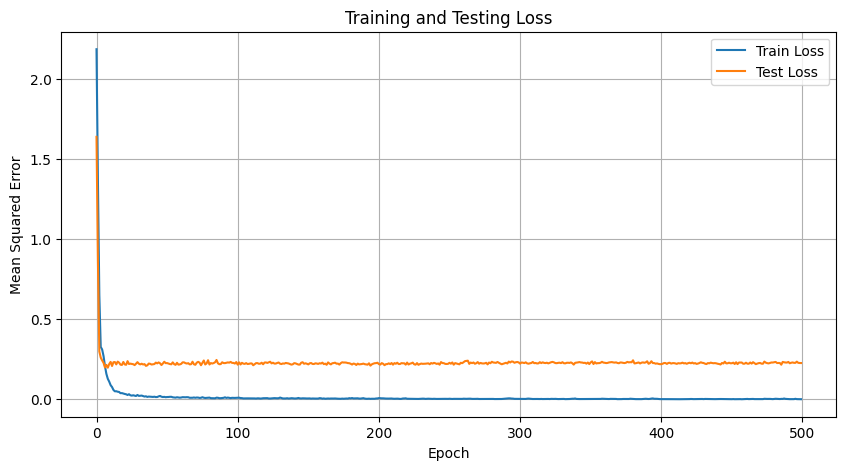

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

MAE: 0.0440, RMSE: 0.0526


/tmp/ipykernel_2837901/3659326996.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor.load_state_dict(torch.load((model_path / f'att_regression_{best_epoch}.pth'),

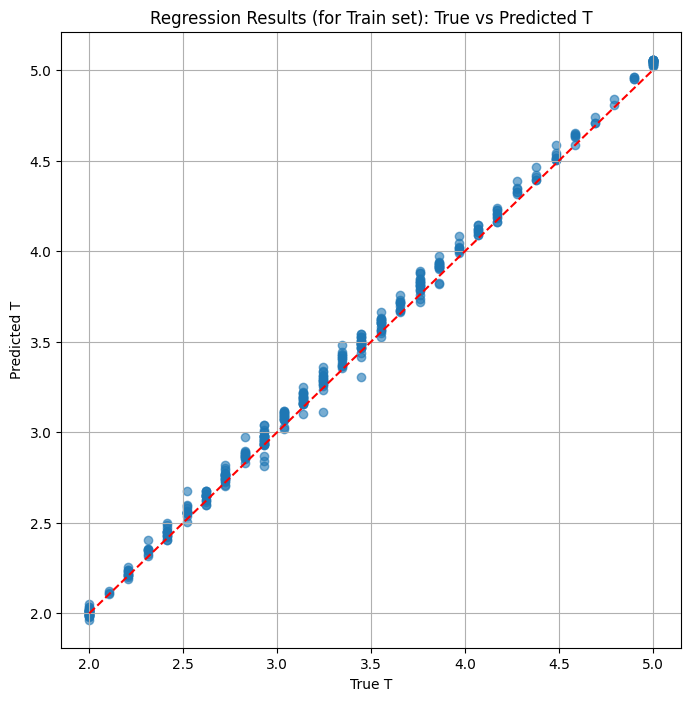

MAE: 0.5470, RMSE: 0.7605


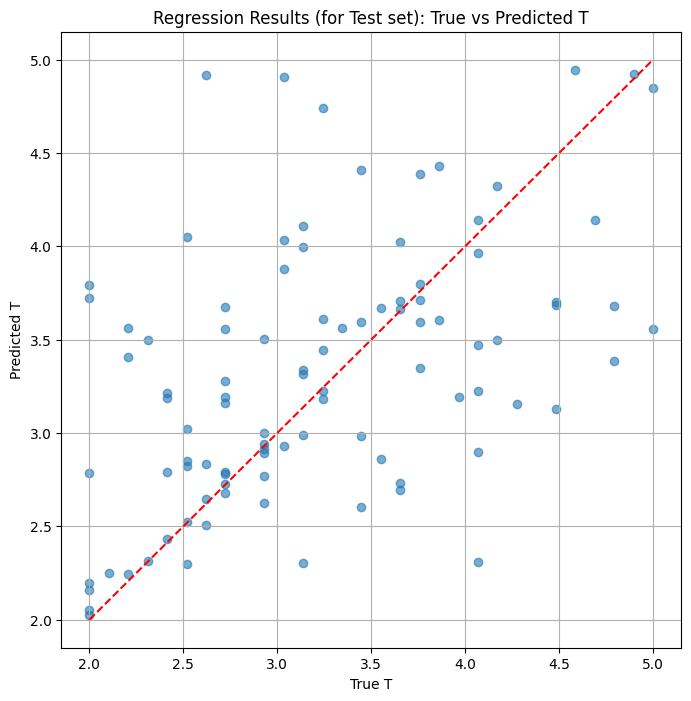

In [13]:
regressor = Regressor(input_dim = 1000, hidden_dim = 64).to(device)
regressor.load_state_dict(torch.load((model_path / f'att_regression_{best_epoch}.pth'), map_location=device))
regressor.eval()

def plot_regression_results(y_true, y_pred, title):
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title(title)
    plt.grid(True)
    plt.show()

with torch.no_grad():
    y_pred = regressor(X_train).cpu().numpy()
    y_true = y_train.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Train set): True vs Predicted T')

    y_pred = regressor(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Test set): True vs Predicted T')

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_2837901/313208723.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default 

lbw_vit_low_feature_L_model2/att_regression_8.pth 1000


100%|██████████| 15/15 [27:11<00:00, 108.79s/it]


모든 이미지 처리 완료!


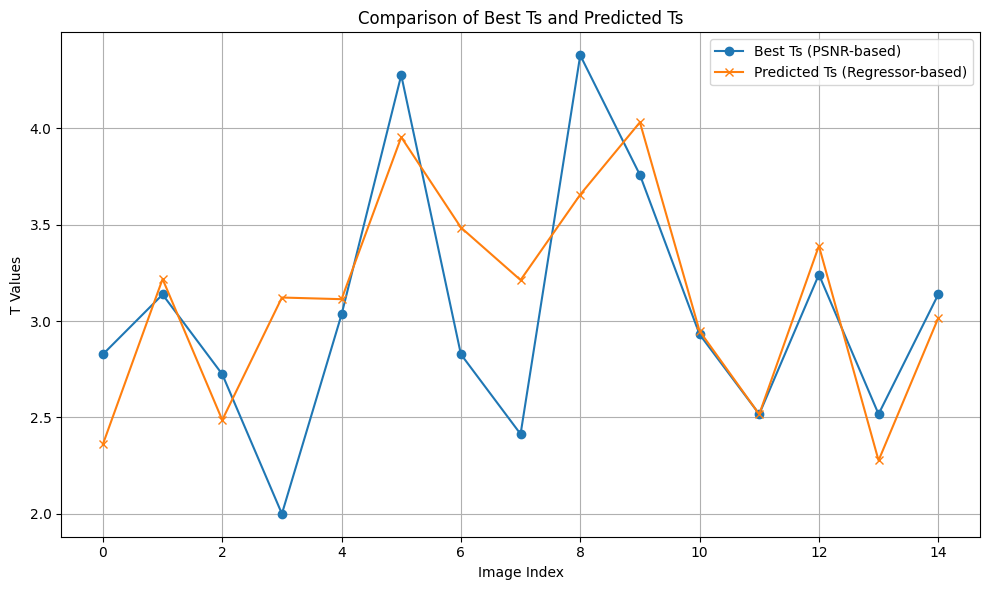

Best T PSNR 평균: 23.52dB
Predicted T PSNR 평균: 20.71dB
Best T SSIM 평균: 0.7517
Predicted T SSIM 평균: 0.7274


In [14]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
# from network.clip_classifier import TtoTClassifier
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment
import time
from network.clip_regressor import TtoTRegressor
from skimage.metrics import structural_similarity as ssim
import timm

# GPU 번호 지정
# gpu_number = 1  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = NODE(device, (3, 400, 600), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/lowlight.pth', weights_only=True), strict=False)

# 하이퍼파라미터 설정
input_dim = 1000
hidden_dim = 64
# num_layers = 3

# 모델 초기화
regressor = Regressor(input_dim, 3, hidden_dim).to(device)
regressor.eval()
regressor.to(device)
model_path_name = (model_path / f'att_regression_{best_epoch}.pth')
# model_path_name = './lbw_low_feature_L_model/att_regression_24.pth'
print(model_path_name, input_dim)
regressor.load_state_dict(torch.load(model_path_name, map_location=device))

vit_encoder = timm.models.vit_large_patch16_224(pretrained=True).to(device)

prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(
    # model_name_or_path="openai/clip-vit-base-patch16",
    model_name_or_path="openai/clip-vit-large-patch14",
    prompts=prompts
).to(device)

def calculate_clip_score(pred, prompts=prompts):    
    # 이미 배치 차원이 있는지 확인하고 없으면 추가
    if len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
    
    with torch.no_grad():
        # 한 번의 forward pass로 모든 프롬프트에 대한 점수를 계산
        scores = clip_metric(pred)
        projection = vit_encoder(pred) # Pooler Output: torch.Size([1, 768])
        
        # scores 딕셔너리를 텐서로 변환
        scores_tensor = torch.tensor([
            scores[prompts[0]].item(),
            scores[prompts[1]].item(),
            scores[prompts[2]].item()
        ], device=device).unsqueeze(0)  # 크기: [1, 3]
        
        # 이미지 임베딩(512차원)과 CLIP 점수(3차원)를 결합 (515차원)
        combined_features = torch.cat([projection, scores_tensor], dim=1)

    return combined_features
# eval15 데이터 불러오기

eval_path = Path('/home/lbw/data/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

def load_eval_image(idx):
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'low' / img_name)
    lq_img_224 = image_tensor(eval_path / 'low' / img_name, size=(224, 224))
    gt_img = image_tensor(eval_path / 'high' / img_name)
    
    return lq_img.to(device), gt_img.to(device), img_name, lq_img_224

def tensor_to_numpy(tensor):
    """PyTorch 텐서를 NumPy 배열로 변환합니다."""
    # GPU -> CPU 이동 및 계산 그래프에서 분리
    img = tensor.detach().cpu().numpy()
    
    # 이미지 형식 변환 (C,H,W) -> (H,W,C)
    if img.ndim == 3 and img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    
    # 값 범위 조정 [0, 1]
    img = np.clip(img, 0, 1)
    
    return img

# 메인 루프 최적화
T_values = np.linspace(2, 5, 30)

# T 값들을 먼저 텐서로 변환하여 반복 변환 방지
T_tensors = [torch.tensor([0, T]).float().cuda() for T in T_values]

# 결과 저장을 위한 디렉토리 생성
results_dir = Path('./CLODE_eval_results_vit_low_feature_L2')
results_dir.mkdir(parents=True, exist_ok=True)

best_Ts = []
pred_Ts = []
best_psnrs = []
pred_psnrs = []
best_ssims = []  # SSIM 결과 저장용
pred_ssims = []  # SSIM 결과 저장용

# 이미지별 NODE와 Classifier 결과 비교
for idx in tqdm(range(len(eval_images))):
    lq_img, gt_img, img_name, lq_img_224 = load_eval_image(idx)
    
    # 모든 T에 대한 예측 수행
    preds = []
    psnrs = []
    ssims = []  # SSIM 값 저장 리스트
    
    with torch.no_grad():
        for T_tensor in T_tensors:
            pred = model(lq_img, T_tensor, inference=True)['output'][0]
            preds.append(pred)
            psnr = calculate_psnr(pred, gt_img).item()
            psnrs.append(psnr)
            # SSIM 계산 추가
            ssim_value = calculate_ssim(pred, gt_img)
            ssims.append(ssim_value)
    
    
    # PSNR 기반 best_T 찾기
    best_T_idx = np.argmax(psnrs)
    best_T = T_values[best_T_idx]
    best_pred = preds[best_T_idx]
    
    best_Ts.append(best_T)
    best_psnrs.append(psnrs[best_T_idx])
    best_ssims.append(ssims[best_T_idx])  # 최적 T의 SSIM 저장
    
    
    # CLIP 점수 계산 및 행렬 구성
    # clip_scores = np.zeros((len(preds), 3))
    # for i, pred in enumerate(preds):
    clip_feature = calculate_clip_score(lq_img_224) # [1, 512]
    # print(clip_feature.shape)
    # mean_exposure = calculate_brightness(lq_img)
    # clip_scores = [bright_score, noise_score, quality_score, mean_exposure]
    
    # Classifier 모델로 예측
    # clip_scores_tensor = torch.FloatTensor(clip_feature).to(device)  # (1, T, 3) 형태로 변환
    with torch.no_grad():
        pred_T = regressor(clip_feature)
        pred_T = pred_T.item()
        
    
    pred_T_idx = np.argmin(np.abs(T_values - pred_T))
    pred_img = preds[pred_T_idx]
    
    pred_Ts.append(pred_T)
    pred_psnrs.append(psnrs[pred_T_idx])
    pred_ssims.append(ssims[pred_T_idx])  # 예측 T의 SSIM 저장
    
    
    # 시각화
    plt.figure(figsize=(20, 15))
    
    # 원본 저화질 이미지
    plt.subplot(2, 2, 1)
    plt.imshow(tensor_to_numpy(lq_img[0]))
    plt.title(f'Low Quality Image: {img_name}')
    plt.axis('off')
    
    # 원본 고화질 이미지
    plt.subplot(2, 2, 2)
    plt.imshow(tensor_to_numpy(gt_img[0]))
    plt.title('Ground Truth')
    plt.axis('off')
    
    # PSNR 기반 best_T 이미지
    plt.subplot(2, 2, 3)
    plt.imshow(tensor_to_numpy(best_pred))
    plt.title(f'NODE Best T={best_T:.2f}, PSNR={psnrs[best_T_idx]:.2f}dB, SSIM={ssims[best_T_idx]:.4f}')
    plt.axis('off')
    
    # Regressor 예측 T 이미지
    plt.subplot(2, 2, 4)
    plt.imshow(tensor_to_numpy(pred_img))
    plt.title(f'Regressor Pred T={pred_T:.2f}, PSNR={psnrs[pred_T_idx]:.2f}dB, SSIM={ssims[pred_T_idx]:.4f}')
    plt.axis('off')
    
    # 결과 저장
    plt.tight_layout()
    plt.savefig(results_dir / f'{img_name.split(".")[0]}_compare.png')
    plt.close()

# 통계 정보 계산 (전체 이미지에 대해)
print("모든 이미지 처리 완료!")

# best_Ts와 pred_Ts를 하나의 플롯에 시각화
plt.figure(figsize=(10, 6))
plt.plot(best_Ts, label='Best Ts (PSNR-based)', marker='o')
plt.plot(pred_Ts, label='Predicted Ts (Regressor-based)', marker='x')
plt.xlabel('Image Index')
plt.ylabel('T Values')
plt.title('Comparison of Best Ts and Predicted Ts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / 'best_vs_pred_Ts.png')
plt.show()

# PSNR 비교
print(f"Best T PSNR 평균: {np.mean(best_psnrs):.2f}dB")
print(f"Predicted T PSNR 평균: {np.mean(pred_psnrs):.2f}dB")
print(f"Best T SSIM 평균: {np.mean(best_ssims):.4f}")
print(f"Predicted T SSIM 평균: {np.mean(pred_ssims):.4f}")


In [ ]:

print(pred_psnrs)
print(pred_ssims)

[19.0980167388916, 23.02713394165039, 24.170167922973633, 9.698051452636719, 23.599071502685547, 20.04595184326172, 16.91597557067871, 13.985651969909668, 17.10015869140625, 19.801443099975586, 26.160524368286133, 25.79684829711914, 21.376440048217773, 22.975711822509766, 25.175630569458008]
[np.float64(0.8064792477737508), np.float64(0.8330329944766998), np.float64(0.8383825762828524), np.float64(0.5708167112585774), np.float64(0.787614617068921), np.float64(0.673905418526756), np.float64(0.6124818329551402), np.float64(0.6940389275713043), np.float64(0.6750911428362866), np.float64(0.5944468810512537), np.float64(0.7963837833317303), np.float64(0.7976106353888146), np.float64(0.6273859991059003), np.float64(0.7266569684704797), np.float64(0.8201802695407355)]
